<a href="https://colab.research.google.com/github/victorsobottka/bse-thesis-synthetic-data/blob/main/2_3_2_LLM_Fine_Tunning_Model_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🧪 Fine-Tunning Approach - Load Pretrained Model and Inference**

**📦 Install dependencies**

In [ ]:
# 🚀 Paso 1: Instalar dependencias
!pip install -q transformers peft accelerate datasets yfinance
!pip -q install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 32.7 MB/s eta 0:00:00


**💽 Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**🪙 Download Real Data**

In [ ]:
# Paso 2: Descargar precios de NVIDIA desde Yahoo Finance
import yfinance as yf
import pandas as pd
import numpy as np
import json

ticker = 'NVDA'
data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
data.reset_index(inplace=True)
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)
data = data[['Date', 'LogReturn']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


**👟 Load Pretrained Model**

In [ ]:
# Load the finetuned model from Google Drive
from peft import PeftModel, PeftConfig
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import re
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import pandas as pd # Import pandas if needed for generated_df later


# Specify the path where the model was saved in Google Drive
output_dir_drive = "/content/drive/MyDrive/deepseek-logreturn-finetuned"

# Define the BitsAndBytes configuration for loading in 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# Check if the directory exists and load the model
if os.path.exists(output_dir_drive):
    # Load the base model with 4-bit quantization directly
    # The PEFT model will be loaded on top of this quantized base model
    model = AutoModelForCausalLM.from_pretrained(
        "deepseek-ai/deepseek-llm-7b-base", # Load the base model ID
        quantization_config=bnb_config,    # Apply quantization here
        torch_dtype=torch.float16,
        device_map="auto"
    )

    # Load the PEFT adapter weights
    # We can load the adapter using the saved directory which contains the adapter weights and configuration
    model = PeftModel.from_pretrained(model, output_dir_drive)

    # Load the tokenizer from the saved directory
    tokenizer = AutoTokenizer.from_pretrained(output_dir_drive)


    print("Model loaded successfully from Google Drive.")
else:
    print(f"Model directory not found at {output_dir_drive}. Please ensure the previous steps were run correctly and the model was saved.")
    # Optionally, you could stop execution or provide a fallback here
    # raise FileNotFoundError(f"Model directory not found at {output_dir_drive}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

Model loaded successfully from Google Drive.


**📤Inference**

In [ ]:
# Paso 9: Generar log-returns sintéticos
prompt = """Generate synthetic log returns for NVIDIA starting from 2020-01-01:
Date: 2020-01-01, LogReturn:"""
# Ensure model is in evaluation mode
model.eval()
# Disable gradient calculations for inference
with torch.no_grad():
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=2500, temperature=0.8)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text) # Print the full generated text


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


Generate synthetic log returns for NVIDIA starting from 2020-01-01:
Date: 2020-01-01, LogReturn: -0.0020
Date: 2020-01-02, LogReturn: 0.0010
Date: 2020-01-03, LogReturn: 0.0043
Date: 2020-01-06, LogReturn: -0.0136
Date: 2020-01-07, LogReturn: 0.0313
Date: 2020-01-08, LogReturn: -0.0377
Date: 2020-01-09, LogReturn: 0.0074
Date: 2020-01-13, LogReturn: 0.0046
Date: 2020-01-14, LogReturn: -0.0313
Date: 2020-01-15, LogReturn: 0.0064
Date: 2020-01-16, LogReturn: -0.0303
Date: 2020-01-17, LogReturn: -0.0342
Date: 2020-01-21, LogReturn: 0.0023
Date: 2020-01-22, LogReturn: -0.0467
Date: 2020-01-23, LogReturn: -0.0176
Date: 2020-01-24, LogReturn: 0.0276
Date: 2020-01-27, LogReturn: -0.0668
Date: 2020-01-28, LogReturn: 0.0671
Date: 2020-01-29, LogReturn: -0.0069
Date: 2020-01-30, LogReturn: -0.0319
Date: 2020-01-31, LogReturn: 0.0114
Date: 2020-02-03, LogReturn: -0.0674
Date: 2020-02-04, LogReturn: -0.0276
Date: 2020-02-05, LogReturn: 0.0312
Date: 2020-02-06, LogReturn: 0.0132
Date: 2020-02-07, L

Extracted 100 generated log returns.


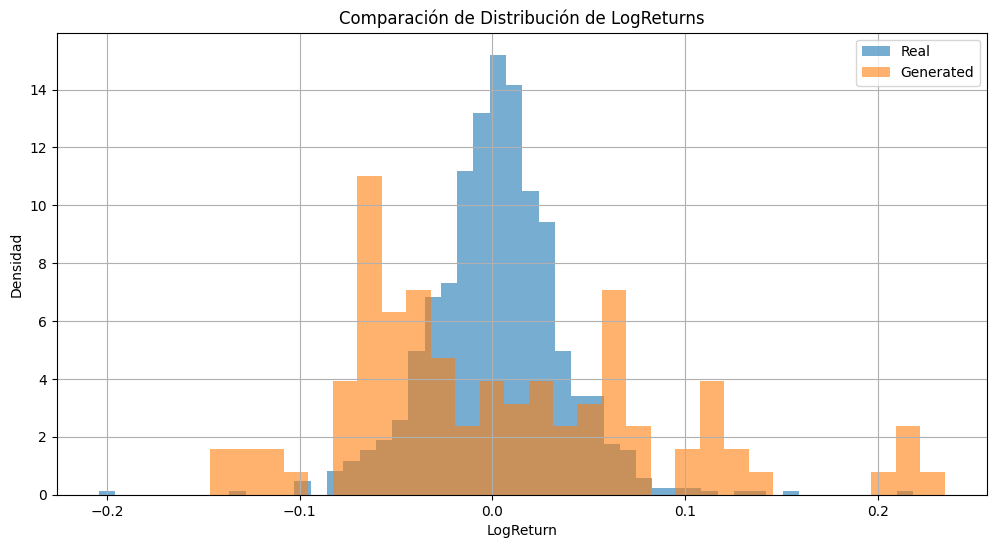

KS Statistic: 0.3198507462686567
P-value: 9.144366420326246e-09
The two distributions are significantly different (reject H0)


In [ ]:
# Paso 10: Comparar distribución real vs generada

if 'data' in globals() and not data.empty:
    real_log_returns = data['LogReturn'].values
else:
    print("Real data ('data' DataFrame) not found. Cannot perform comparison.")
    real_log_returns = None # Set to None if data is missing


# Extraer valores generados del texto
generated_values = []
try:
    generated_values = [float(x) for x in re.findall(r"LogReturn:\s*(-?\d+\.\d+)", generated_text)]
    print(f"Extracted {len(generated_values)} generated log returns.")
except ValueError as e:
    print(f"Could not parse generated text into floats: {e}")
    generated_values = []

# Extract dates from the generated text for the table later
generated_dates = [d for d in re.findall(r"Date:\s*(\d{4}-\d{2}-\d{2})", generated_text)]

# Ensure the lengths of dates and values match for the table
min_len = min(len(generated_dates), len(generated_values))
generated_dates = generated_dates[:min_len]
generated_values_for_table = generated_values[:min_len] # Keep a separate list for table if needed


if real_log_returns is not None and generated_values:
    # Visualizar distribuciones
    plt.figure(figsize=(12, 6))

   # Plot comparación
    plt.hist(real_log_returns, bins=50, alpha=0.6, label='Real', density=True)
    plt.hist(generated_values, bins=30, alpha=0.6, label='Generated', density=True)
    plt.legend()
    plt.title("Comparación de Distribución de LogReturns")
    plt.xlabel("LogReturn")
    plt.ylabel("Densidad")
    plt.grid(True)
    plt.show()


    # Realizar test KS
    if len(generated_values) > 0 and len(real_log_returns) > 0:
        # To compare the distributions, ks_2samp can handle different lengths.
        ks_statistic, p_value = ks_2samp(real_log_returns, generated_values)
        print(f"KS Statistic: {ks_statistic}")
        print(f"P-value: {p_value}")

        alpha = 0.05
        if p_value > alpha:
            print("The two distributions are not significantly different (fail to reject H0)")
        else:
            print("The two distributions are significantly different (reject H0)")
    else:
        print("Cannot perform KS test due to insufficient data points in either real or generated values.")

else:
    print("Comparison and KS test skipped due to missing real or generated data.")




In [ ]:
# If you want to display the generated data in a table as in Paso 11
if generated_dates and generated_values_for_table:
    generated_df = pd.DataFrame({
        'Date': generated_dates,
        'Generated LogReturn': generated_values_for_table
    })
    print("\nGenerated Log Returns (Table):")
    from google.colab import data_table
    data_table.enable_dataframe_formatter()
    display(generated_df)
elif generated_values:
    print("\nGenerated Log Returns (List):")
    print(generated_values)


Generated Log Returns (Table):


,Date,Generated LogReturn
0,2020-01-01,-0.0020
1,2020-01-02,0.0010
2,2020-01-03,0.0043
3,2020-01-06,-0.0136
4,2020-01-07,0.0313
...,...,...
95,2020-05-19,-0.0414
96,2020-05-20,-0.0306
97,2020-05-21,0.0576
98,2020-05-22,-0.0346


<ipython-input-20-ffe5fcfe850b>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Type', y='Returns', palette=['#1f77b4', '#ff7f0e'])


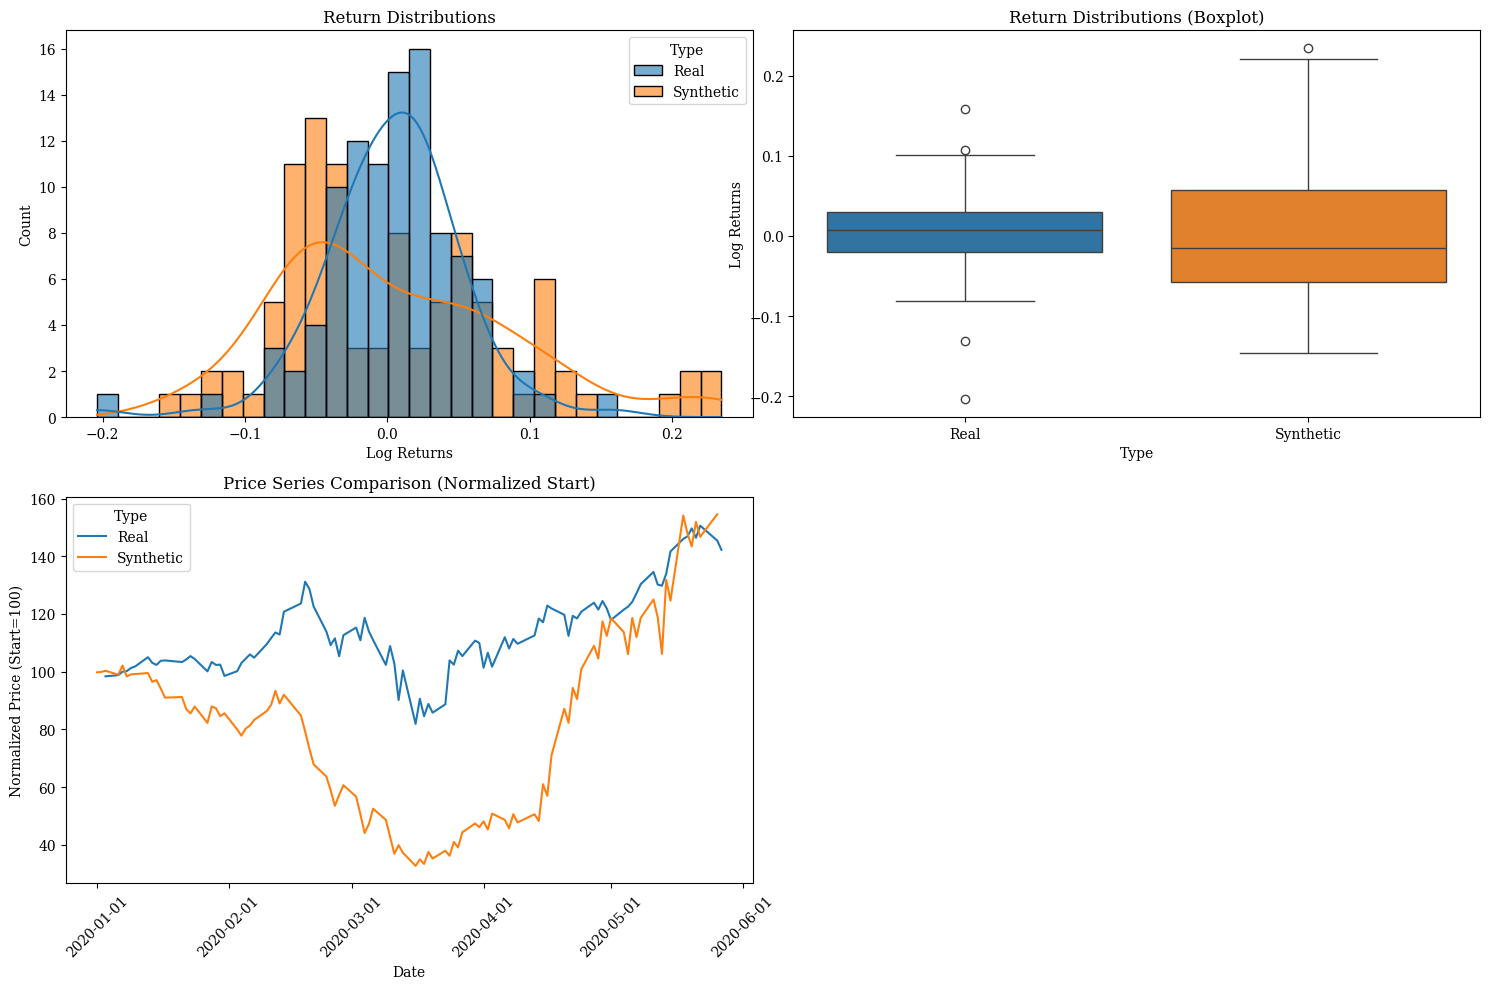


--- Statistical Summary of Returns ---
Real Returns:
count    100.000000
mean       0.003522
std        0.048402
min       -0.203980
25%       -0.019812
50%        0.007335
75%        0.029764
max        0.158340
dtype: float64

Synthetic Returns:
count    100.000000
mean       0.004353
std        0.082967
min       -0.146300
25%       -0.057500
50%       -0.015600
75%        0.057675
max        0.234600
dtype: float64

--- Kolmogorov-Smirnov Test ---
KS Statistic: 0.28
P-value: 0.0007377026282063397
The two distributions are significantly different (reject H0).

--- T-test (Welch's) ---
  Statistic: -0.0865
  p-value: 0.9312


In [ ]:
# prompt: for another project I have this amazing code I would like to replicate this charts import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.dates as mdates
from scipy.stats import ks_2samp # Ensure ks_2samp is imported if used outside the commented block

plt.rcParams['font.family'] = 'serif'


def plot_and_analyze(sequences, synthetic_data):
    """
    Compares real vs. synthetic financial time series with:
    - Return distribution plots
    - Price series comparison
    - Statistical summary and tests
    Parameters:
    - sequences: DataFrame with 'Date' and 'LogReturn' for real data
    - synthetic_data: DataFrame with 'Date' and 'LogReturn' for synthetic data
    """
    # 1. Extract sequences
    real_returns = sequences['LogReturn'].to_numpy().flatten()
    synthetic_returns = synthetic_data['LogReturn'].to_numpy().flatten()
    real_dates = pd.to_datetime(sequences['Date'])
    synthetic_dates = pd.to_datetime(synthetic_data['Date'])

    # 2. Convert log returns to price series
    def returns_to_prices(returns):
        # Start with a base price (e.g., 100) and apply cumulative log returns
        # exp(cumsum(log_returns)) gives the price relative to the start
        log_prices = np.cumsum(returns)
        return np.exp(log_prices) * 100  # Starting price = 100

    # Ensure the lengths match for price conversion; use the minimum length
    min_returns_len = min(len(real_returns), len(synthetic_returns))

    # Truncate returns and dates to the minimum length for price conversion and plotting
    real_returns_truncated = real_returns[:min_returns_len]
    synthetic_returns_truncated = synthetic_returns[:min_returns_len]
    real_dates_truncated = real_dates[:min_returns_len]
    synthetic_dates_truncated = synthetic_dates[:min_returns_len]

    real_prices = returns_to_prices(real_returns_truncated)
    synthetic_prices = returns_to_prices(synthetic_returns_truncated)


    # 3. Combine into one DataFrame for plotting
    # Use the truncated lengths for all concatenated arrays
    df = pd.DataFrame({
        'Returns': np.concatenate([real_returns_truncated, synthetic_returns_truncated]),
        'Prices': np.concatenate([real_prices, synthetic_prices]),
        # Use the truncated lengths for the 'Type' list as well
        'Type': ['Real']*min_returns_len + ['Synthetic']*min_returns_len,
        # Use the truncated dates for the 'Date' column
        'Date': np.concatenate([real_dates_truncated, synthetic_dates_truncated])
    })

    # 4. Generate plots
    plt.figure(figsize=(15, 10))

    # Plot 1: Histogram of returns
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='Returns', hue='Type', kde=True, bins=30, alpha=0.6,
                 palette=['#1f77b4', '#ff7f0e'])
    plt.title('Return Distributions')
    plt.xlabel('Log Returns')
    plt.ylabel('Count')

    # Plot 2: Price series comparison
    plt.subplot(2, 2, 3)
    # Filter df for prices plotting if needed, but the concatenation should handle it
    sns.lineplot(data=df, x='Date', y='Prices', hue='Type', palette=['#1f77b4', '#ff7f0e'])
    plt.title('Price Series Comparison (Normalized Start)')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price (Start=100)')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # Use AutoDateLocator for flexible date ticks
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.tight_layout() # Adjust layout to prevent overlap

    # Plot 2: Boxplot of returns
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='Type', y='Returns', palette=['#1f77b4', '#ff7f0e'])
    plt.title('Return Distributions (Boxplot)')
    plt.ylabel('Log Returns')

    plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/thesis/llm_outputs/llm_finetunning_analysis.png", dpi=300, bbox_inches='tight')


    plt.show()

    # 5. Statistical summary and tests
    # Use the original returns for the statistical summary and KS test as they can handle different lengths
    print("\n--- Statistical Summary of Returns ---")
    print("Real Returns:")
    print(pd.Series(real_returns_truncated).describe())
    print("\nSynthetic Returns:")
    print(pd.Series(synthetic_returns_truncated).describe())

    print("\n--- Kolmogorov-Smirnov Test ---")
    # Perform KS test to compare the distributions
    # KS test can handle different sample sizes
    ks_statistic, p_value = ks_2samp(real_returns_truncated, synthetic_returns_truncated)
    print(f"KS Statistic: {ks_statistic}")
    print(f"P-value: {p_value}")

    alpha = 0.05
    if p_value > alpha:
        print("The two distributions are not significantly different (fail to reject H0).")
    else:
        print("The two distributions are significantly different (reject H0).")


    # Use the df_returns DataFrame created for plotting the return distributions
    t_stat, t_p = stats.ttest_ind(
        df[df['Type'] == 'Real']['Returns'],
        df[df['Type'] == 'Synthetic']['Returns'],
        equal_var=False # Use Welch's t-test
    )
    print(f"\n--- T-test (Welch's) ---")
    print(f"  Statistic: {t_stat:.4f}")
    print(f"  p-value: {t_p:.4f}")

# --- End of plot_and_analyze function definition ---


# Assuming 'data' is the real DataFrame and 'generated_df' is the synthetic one
# Make sure 'generated_df' has a 'LogReturn' column name that matches 'data'
# If 'generated_df' was created earlier with 'Generated LogReturn', rename it
if 'generated_df' in globals() and 'Generated LogReturn' in generated_df.columns:
    generated_df.rename(columns={'Generated LogReturn': 'LogReturn'}, inplace=True)

# Recreate generated_df just before calling plot_and_analyze if it wasn't created in the previous cell
# based on the previous code's generated_dates and generated_values_for_table
# This ensures generated_df exists with the correct 'LogReturn' column name
if 'generated_dates' in globals() and 'generated_values_for_table' in globals() and generated_dates and generated_values_for_table:
    generated_df = pd.DataFrame({
        'Date': generated_dates,
        'LogReturn': generated_values_for_table # Use 'LogReturn' directly
    })
elif 'generated_df' not in globals() or generated_df.empty:
    print("Cannot create synthetic DataFrame for plotting.")
    generated_df = pd.DataFrame({'Date': [], 'LogReturn': []}) # Create empty df if no data


# Now call the function with the actual DataFrames
if 'data' in globals() and not data.empty and not generated_df.empty:
    plot_and_analyze(data, generated_df)
else:
    print("Skipping plot and analysis due to empty real or synthetic data.")

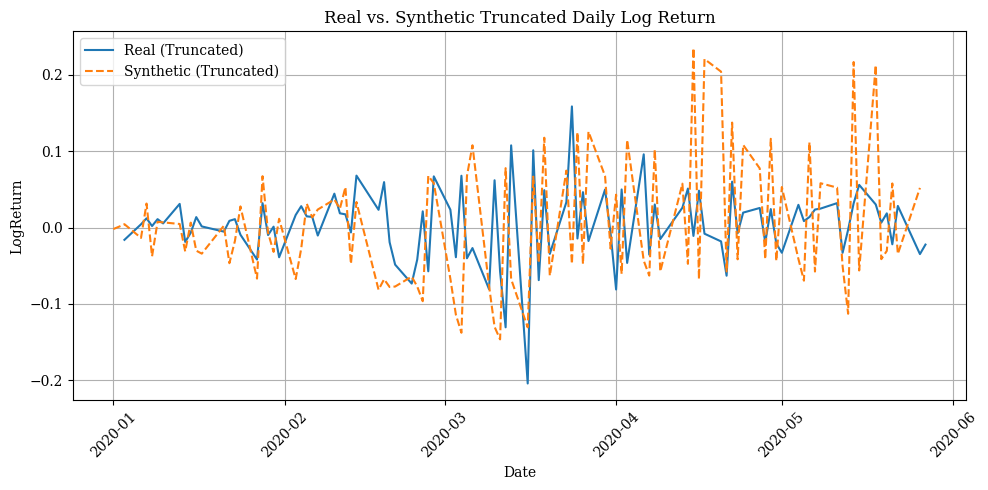

In [ ]:
# prompt: need this chart but comparing real and generated truncated data plt.figure(figsize=(10, 5))
# plt.plot(df_real['Date'], df_real['LogReturn'], label='Real')
# plt.plot(df_synthetic['Date'], df_synthetic['LogReturn'], linestyle="--",  label='Synthetic')
# plt.title("Synthetic NVIDIA Daily Log Return")
# plt.xlabel("Date")
# plt.ylabel("Close")
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# # Add legend
# plt.legend()
# plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/thesis/llm_outputs/llm_{prompt_mode}_daily_logreturn.png", dpi=300, bbox_inches='tight')
# plt.show()

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates # Import mdates if not already imported

plt.figure(figsize=(10, 5))

# Replicate the data preparation for the truncated time series plot
# Ensure 'data' and 'generated_df' (with 'LogReturn' and 'Date') exist and are not empty

if 'data' in globals() and not data.empty and 'generated_df' in globals() and not generated_df.empty:

    # Extract real and synthetic data
    real_returns = data['LogReturn'].to_numpy().flatten()
    synthetic_returns = generated_df['LogReturn'].to_numpy().flatten() # Use generated_df here
    real_dates = pd.to_datetime(data['Date'])
    synthetic_dates = pd.to_datetime(generated_df['Date']) # Use generated_df here

    # Determine minimum length for truncation
    min_returns_len = min(len(real_returns), len(synthetic_returns))

    # Truncate data
    real_returns_truncated = real_returns[:min_returns_len]
    synthetic_returns_truncated = synthetic_returns[:min_returns_len]
    real_dates_truncated = real_dates[:min_returns_len]
    synthetic_dates_truncated = synthetic_dates[:min_returns_len]

    # Create separate dataframes for truncated real and synthetic data for plotting
    df_real_truncated = pd.DataFrame({
        'Date': real_dates_truncated,
        'LogReturn': real_returns_truncated
    })

    df_synthetic_truncated = pd.DataFrame({
        'Date': synthetic_dates_truncated,
        'LogReturn': synthetic_returns_truncated
    })


    # Now plot the truncated dataframes
    plt.plot(df_real_truncated['Date'], df_real_truncated['LogReturn'], label='Real (Truncated)')
    plt.plot(df_synthetic_truncated['Date'], df_synthetic_truncated['LogReturn'], linestyle="--",  label='Synthetic (Truncated)')

    plt.title("Real vs. Synthetic Truncated Daily Log Return")
    plt.xlabel("Date")
    plt.ylabel("LogReturn")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Add legend
    plt.legend()

    # Save the figure
    # Construct filename - you might need to define `prompt_mode` or adjust the filename
    # For example, you can use a static name or a parameter if prompt_mode is not available
    # prompt_mode = "example_mode" # Define or get this variable
    # plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/thesis/llm_outputs/llm_{prompt_mode}_truncated_daily_logreturn.png", dpi=300, bbox_inches='tight')

    # Save with a static name if prompt_mode is not defined or available in this scope
    plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/thesis/llm_outputs/llm_daily_finetunning_logreturn_comparison.png", dpi=300, bbox_inches='tight')

    plt.show()
else:
    print("Skipping truncated time series plot due to missing real or synthetic data.")
    print(f"Data exists: {'data' in globals() and not data.empty}")
    print(f"Generated data exists: {'generated_df' in globals() and not generated_df.empty}")

In [ ]:
#Export the truncated generated dataset to google drive

output_file_path = '/content/drive/MyDrive/Colab Notebooks/thesis/llm_outputs/llm_finetunning_generated_dataset.csv'
generated_df.to_csv(output_file_path, index=False)
print(f"\nTruncated generated dataset exported to: {output_file_path}")



Truncated generated dataset exported to: /content/drive/MyDrive/Colab Notebooks/thesis/llm_outputs/llm_finetunning_generated_dataset.csv
